# Variational PINN learning of 2D Poisson Equation

Consider the 2D Poisson equation $ u_{xx} + u_{yy} = f(x) $. An exact solution to this equation is

$$ u(x) = \big[ A \sin(\omega x) + B x^2 \big] \sin(\omega y) $$

$$ \nabla^2 u(x) = -\big[2 A \omega^2 \sin(\omega x) + B(\omega^2 x^2 - 2)\big] \sin(\omega y) $$

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, '$u_{xx} - f$')

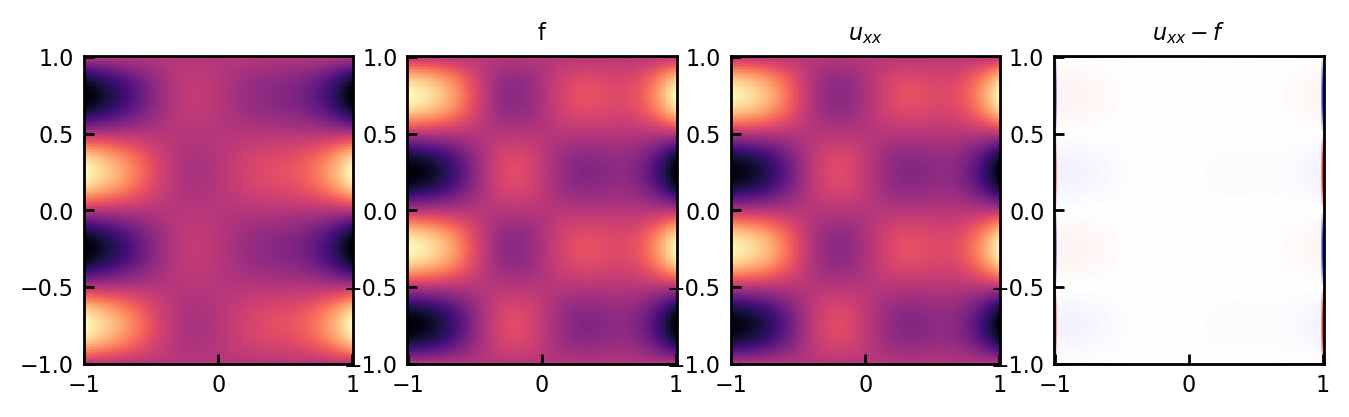

In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('../../figure_style.mplstyle')

A = 0.1
B = 1.
omega = 2 * np.pi
N = 200

u = lambda x, y: (A * np.sin(omega * x) + B * x**2) * np.sin(omega * y)
f = lambda x, y: -np.sin(omega * y) * (2 * A * omega**2 * np.sin(omega * x) + B * (omega**2 * x**2 - 2))
X_star, Y_star = np.meshgrid(
    np.linspace(-1, 1, N),
    np.linspace(-1, 1, N),
    indexing='xy')

F_star = f(X_star, Y_star)
U_star = u(X_star, Y_star)

xx = X_star.flatten()[:, None]
yy = Y_star.flatten()[:, None]
uu = U_star.flatten()[:, None]

fig, ax = plt.subplots(1, 4, figsize=(8, 2))
ax[0].pcolormesh(X_star, Y_star, U_star, cmap='magma')
ax[1].set_title('u')

ax[1].pcolormesh(X_star, Y_star, F_star, cmap='magma')
ax[1].set_title('f')

dx = X_star[1,1] - X_star[0,0]
dy = Y_star[1,1] - Y_star[0,0]
lapl = np.gradient(np.gradient(U_star, dx, axis=0), dx, axis=0) + np.gradient(np.gradient(U_star, dy, axis=1), dy, axis=1)
ax[2].pcolormesh(X_star, Y_star, lapl, cmap='magma')
ax[2].set_title('$u_{xx}$')

ax[3].pcolormesh(X_star, Y_star, F_star - lapl, cmap='bwr', vmin=-1, vmax=1)
ax[3].set_title('$u_{xx} - f$')



## Boundary value problem

0.1 1.0 6.283185307179586


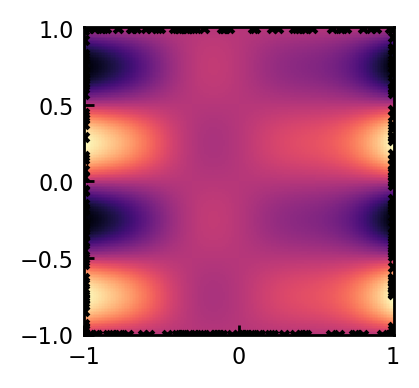

In [32]:
#Select boundary points for reconstruction loss
N_b = 200
idx = np.argwhere(np.logical_or(
    np.logical_or(xx == xx.min(), xx == xx.max()),
    np.logical_or(yy == yy.min(), yy == yy.max())
))[:,0]
idx = np.random.choice(idx, N_b, replace=False)
x_b, y_b, u_b = xx[idx, :], yy[idx, :], uu[idx, :]

print(A, B, omega)

# Plot both sets of points
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.pcolormesh(X_star, Y_star, U_star, vmin=-1, vmax=1, cmap='magma')
ax.scatter(x_b, y_b, c='black', marker='x', s=10)

In [47]:
import torch
from poisson_variational_pinn import PoissonBVPVariationalPINN

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Starting to train on device {device}')

model = PoissonBVPVariationalPINN(
    data=dict(
        x_u=x_b,
        y_u=y_b,
        u_u=u_b,
    ),
).to(device)
model.train(1)

Starting to train on device cuda:0
Iteration 1000, Loss: 5.19250e-04, MSE: 1.24915e-04, Phys: 3.94335e-04
Iteration 2000, Loss: 1.23226e-04, MSE: 1.60809e-05, Phys: 1.07146e-04
Iteration 3000, Loss: 3.83288e-05, MSE: 1.01197e-05, Phys: 2.82091e-05
Iteration 4000, Loss: 1.74858e-05, MSE: 3.68170e-06, Phys: 1.38041e-05
Iteration 5000, Loss: 6.96655e-06, MSE: 1.33148e-06, Phys: 5.63507e-06


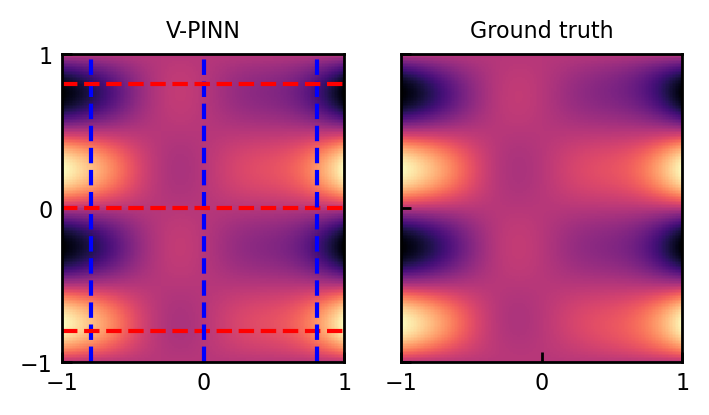

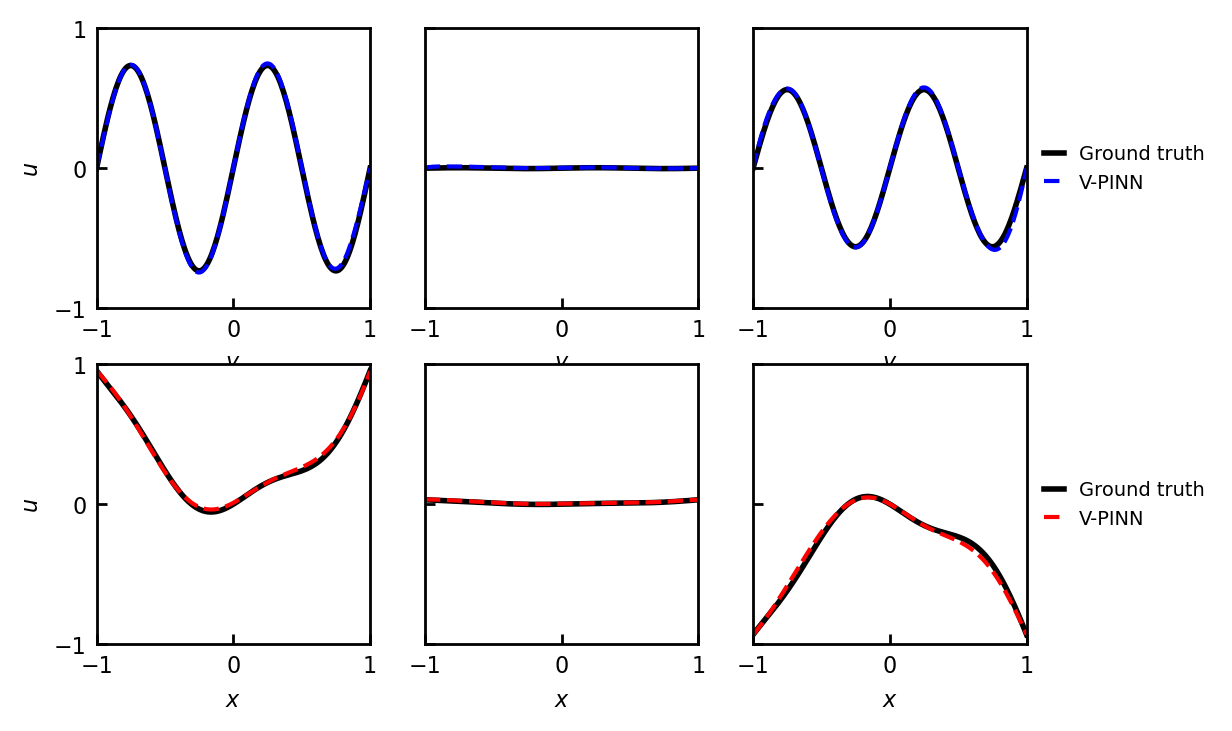

In [78]:
XY_star = torch.FloatTensor(np.stack([X_star, Y_star], axis=-1)).to(device)
U_pred = model.forward(XY_star).detach().cpu().numpy().squeeze()

fig1, ax1 = plt.subplots(1, 2, figsize=(4, 2), sharex=True, sharey=True)

ax1[0].pcolormesh(X_star, Y_star, U_star, cmap='magma', vmin=-1, vmax=1)
ax1[1].pcolormesh(X_star, Y_star, U_pred, cmap='magma', vmin=-1, vmax=1)

fig2, ax2 = plt.subplots(2, 3, figsize=(6, 4), sharex='row', sharey=True)
for i, idx in enumerate([20, 100, 180]):
    x0 = X_star[0, idx]
    y0 = Y_star[idx, 0]

    kwargs = dict(color='blue', linestyle='--')
    slc = np.s_[:, idx]
    ax1[0].axvline(x0, **kwargs)
    ax2[0,i].plot(Y_star[slc], U_star[slc], color='black', linewidth=2, label='Ground truth')
    ax2[0,i].plot(Y_star[slc], U_pred[slc], label='V-PINN', **kwargs)

    kwargs = dict(color='red', linestyle='--')
    slc = np.s_[idx, :]
    ax1[0].axhline(y0, **kwargs)
    ax2[1,i].plot(X_star[slc], U_star[slc], color='black', linewidth=2, label='Ground truth')
    ax2[1,i].plot(X_star[slc], U_pred[slc], label='V-PINN', **kwargs)

for a in ax1:
    a.set(
        xlim=[-1,1], xticks=[-1,0,1],
        ylim=[-1,1], yticks=[-1,0,1],
    )
ax1[0].set_title('V-PINN')
ax1[1].set_title('Ground truth')

for a in ax2.flatten():
    a.set(
        xlim=[-1,1], xticks=[-1,0,1],
        ylim=[-1,1], yticks=[-1,0,1],
    )

for a in ax2[0]: a.set_xlabel('$y$')
for a in ax2[1]: a.set_xlabel('$x$')
ax2[0,0].set_ylabel('$u$')
ax2[1,0].set_ylabel('$u$')
ax2[0,2].legend(loc='center left', bbox_to_anchor=[1, 0.5])
ax2[1,2].legend(loc='center left', bbox_to_anchor=[1, 0.5])